Starting analysis...
Generating Lorenz data...
Training model...


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Preparing SHAP analysis...
Calculating SHAP values...
SHAP values shape after reshape: (10, 20)
Test data shape: (10, 20)


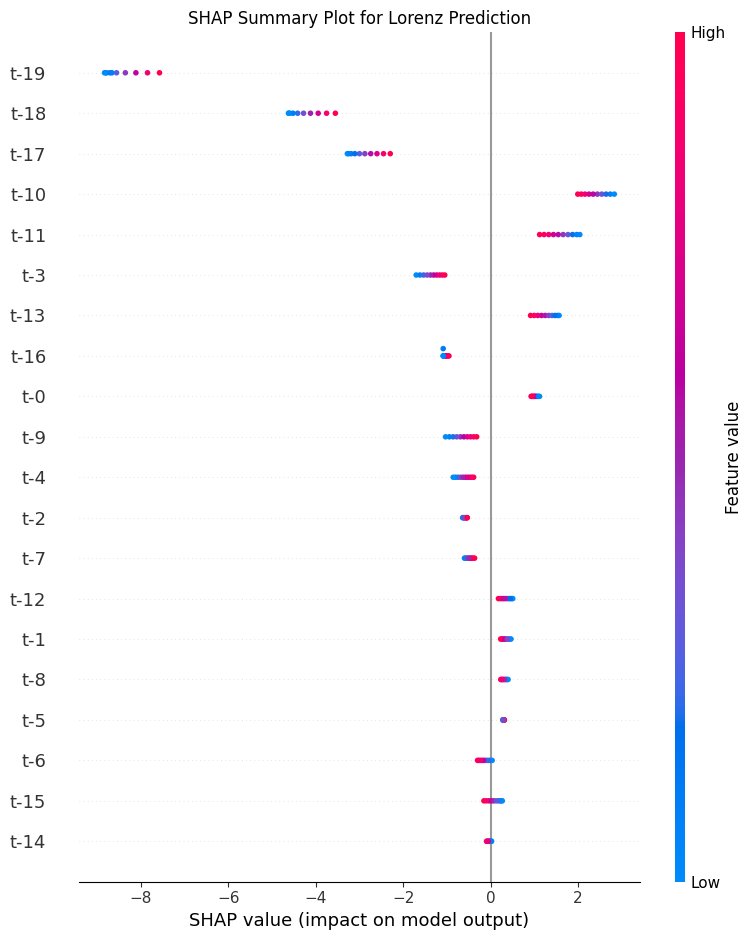

<Figure size 1200x600 with 0 Axes>

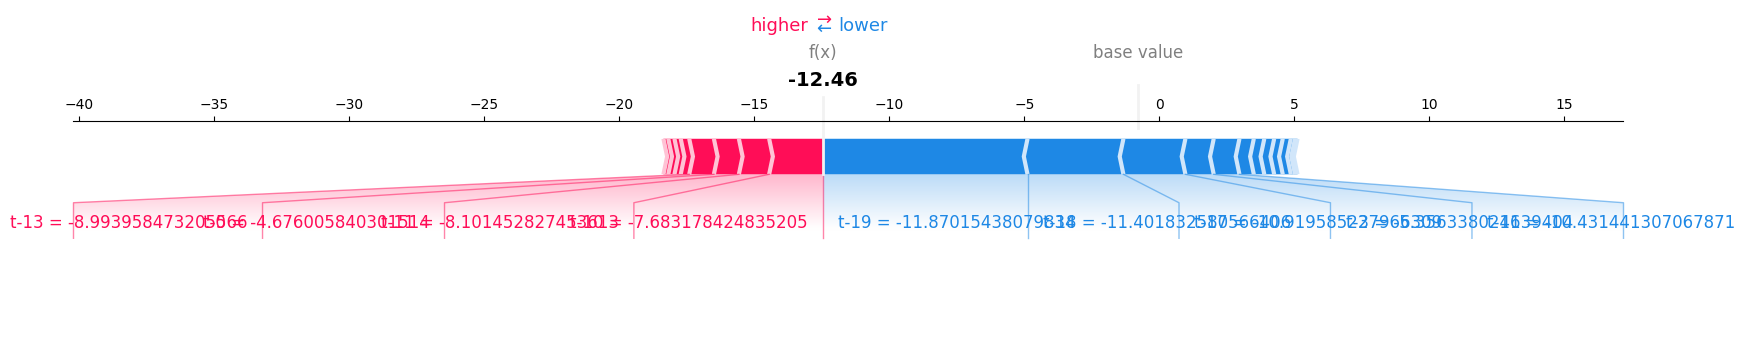

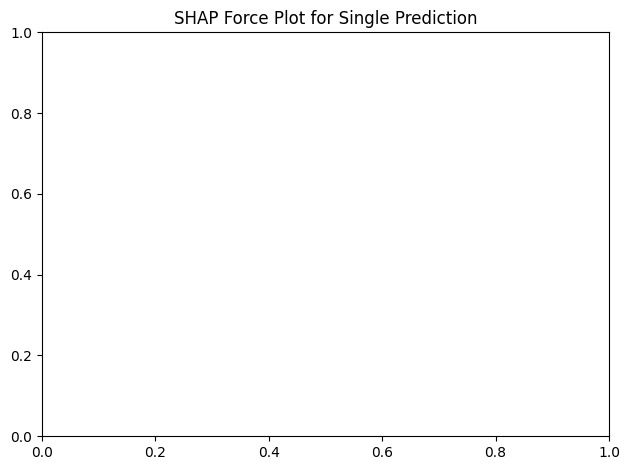


Feature Importance Summary:
t-19: 8.4257
t-18: 4.2420
t-17: 2.8793
t-10: 2.4021
t-11: 1.5973
t-3: 1.3538
t-13: 1.2716
t-16: 1.0386
t-0: 1.0182
t-9: 0.6601
t-4: 0.6106
t-2: 0.5831
t-7: 0.4859
t-12: 0.3554
t-1: 0.3431
t-8: 0.3127
t-5: 0.2968
t-6: 0.1481
t-15: 0.1413
t-14: 0.0401

Analysis completed in 9.62 seconds


In [ ]:
# First install required packages
!pip install shap tqdm IPython

import torch
import torch.nn as nn
import numpy as np
import shap
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Audio, display
import time

# Define the standard network (copied from experiment_harness.py)
def create_standard_net(sequence_length=20, hidden_dims=[64, 32, 16]):
    return nn.Sequential(
        nn.Linear(sequence_length, hidden_dims[0]),
        nn.ReLU(),
        nn.Linear(hidden_dims[0], hidden_dims[1]),
        nn.ReLU(),
        nn.Linear(hidden_dims[1], hidden_dims[2]),
        nn.ReLU(),
        nn.Linear(hidden_dims[2], 1)
    )

# Generate Lorenz data
def generate_lorenz_data(n_samples=1000, sequence_length=20):
    def lorenz(x, y, z, s=10, r=28, b=2.667):
        x_dot = s*(y - x)
        y_dot = r*x - y - x*z
        z_dot = x*y - b*z
        return x_dot, y_dot, z_dot

    dt = 0.01
    x, y, z = 1, 1, 1
    data = []
    for i in range(n_samples):
        dx, dy, dz = lorenz(x, y, z)
        x = x + dx * dt
        y = y + dy * dt
        z = z + dz * dt
        data.append(x)

    X = np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])
    y = np.array([data[i+sequence_length] for i in range(len(data) - sequence_length)])

    return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)

# Train the model
def train_model(model, X, y, epochs=100, batch_size=32):
    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()

    # Create progress bar for epochs
    pbar = tqdm(range(epochs), desc='Training')

    for epoch in pbar:
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(train_loader)
        pbar.set_postfix({'loss': f'{avg_loss:.4f}'})

    return model

# Create a wrapper for SHAP
class ShapWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.FloatTensor(x)
        return self.model(x)

def play_completion_sound():
    # Generate a simple beep sound
    sample_rate = 44100
    duration = 1  # seconds
    frequency = 440  # Hz (A4 note)
    t = np.linspace(0, duration, int(sample_rate * duration))
    signal = np.sin(2 * np.pi * frequency * t)
    return Audio(signal, rate=sample_rate, autoplay=True)

# Main execution
if __name__ == "__main__":
    print("Starting analysis...")
    start_time = time.time()

    # Generate data
    print("Generating Lorenz data...")
    sequence_length = 20
    n_samples = 1000
    X, y = generate_lorenz_data(n_samples=n_samples, sequence_length=sequence_length)

    # Create and train model
    print("Training model...")
    model = create_standard_net(sequence_length=sequence_length)
    trained_model = train_model(model, X, y)

    # Prepare model for SHAP
    print("Preparing SHAP analysis...")
    trained_model.eval()
    shap_wrapper = ShapWrapper(trained_model)

    # Create background data for SHAP (using first 100 samples)
    background_tensor = X[:100]  # Keep as PyTorch tensor

    # Select test instances for explanation (using next 10 samples)
    test_tensor = X[100:110]    # Keep as PyTorch tensor

    # Initialize SHAP explainer
    print("Calculating SHAP values...")
    explainer = shap.DeepExplainer(shap_wrapper, background_tensor)

    # Calculate SHAP values and reshape
    shap_values = explainer.shap_values(test_tensor)
    shap_values = np.array(shap_values).squeeze()  # Remove the extra dimension

    # Convert to numpy for plotting
    test_data_numpy = test_tensor.numpy()

    # Print shapes for debugging
    print(f"SHAP values shape after reshape: {shap_values.shape}")
    print(f"Test data shape: {test_data_numpy.shape}")

    # Create feature names list
    feature_names = [f"t-{i}" for i in range(sequence_length)]

    # Plot SHAP summary
    plt.figure(figsize=(12, 6))
    shap.summary_plot(
        shap_values,
        test_data_numpy,
        feature_names=feature_names,
        show=False
    )
    plt.title("SHAP Summary Plot for Lorenz Prediction")
    plt.tight_layout()
    plt.show()

    # Plot individual SHAP explanation for first test instance
    plt.figure(figsize=(12, 6))
    shap.force_plot(
        explainer.expected_value[0],
        shap_values[0,:],  # Use reshaped values
        test_data_numpy[0],
        feature_names=feature_names,
        matplotlib=True
    )
    plt.title("SHAP Force Plot for Single Prediction")
    plt.tight_layout()
    plt.show()

    # Print feature importance summary
    print("\nFeature Importance Summary:")
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    feature_importance = list(zip(feature_names, mean_abs_shap))
    sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

    for feature, importance in sorted_importance:
        print(f"{feature}: {importance:.4f}")

    # Print completion time and play sound
    end_time = time.time()
    print(f"\nAnalysis completed in {end_time - start_time:.2f} seconds")
    display(play_completion_sound())

Starting analysis...
Generating Lorenz data...
Training model...


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Preparing SHAP analysis...
Calculating SHAP values...


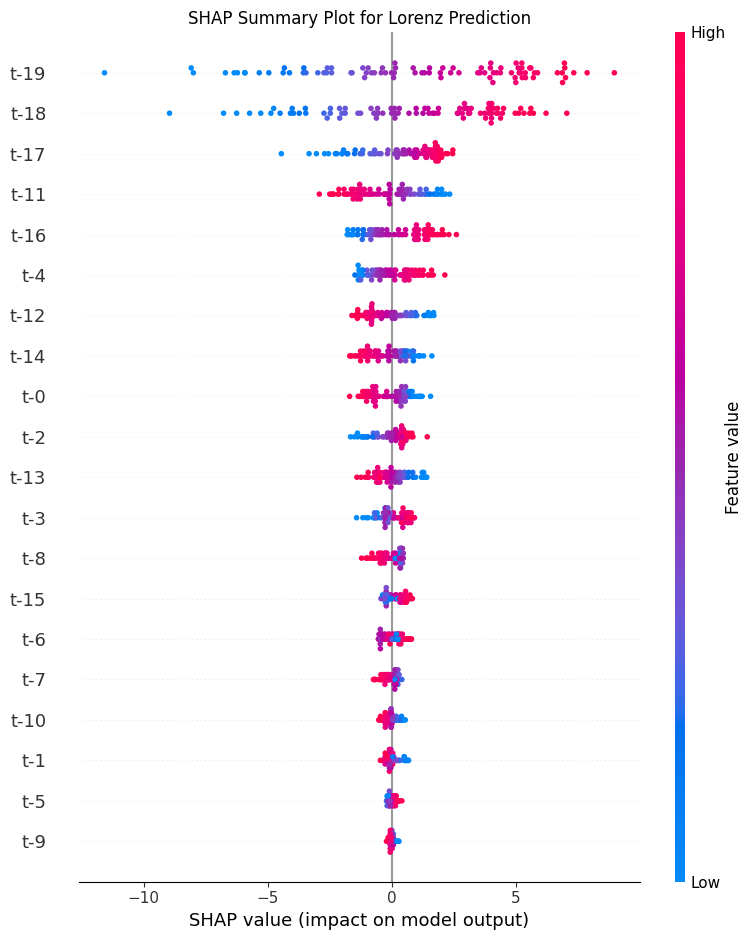


Creating Lorenz attractor visualization...
SHAP value statistics:
Mean: 0.8407
Min: 0.2118
Max: 1.9242
Number of test points: 88


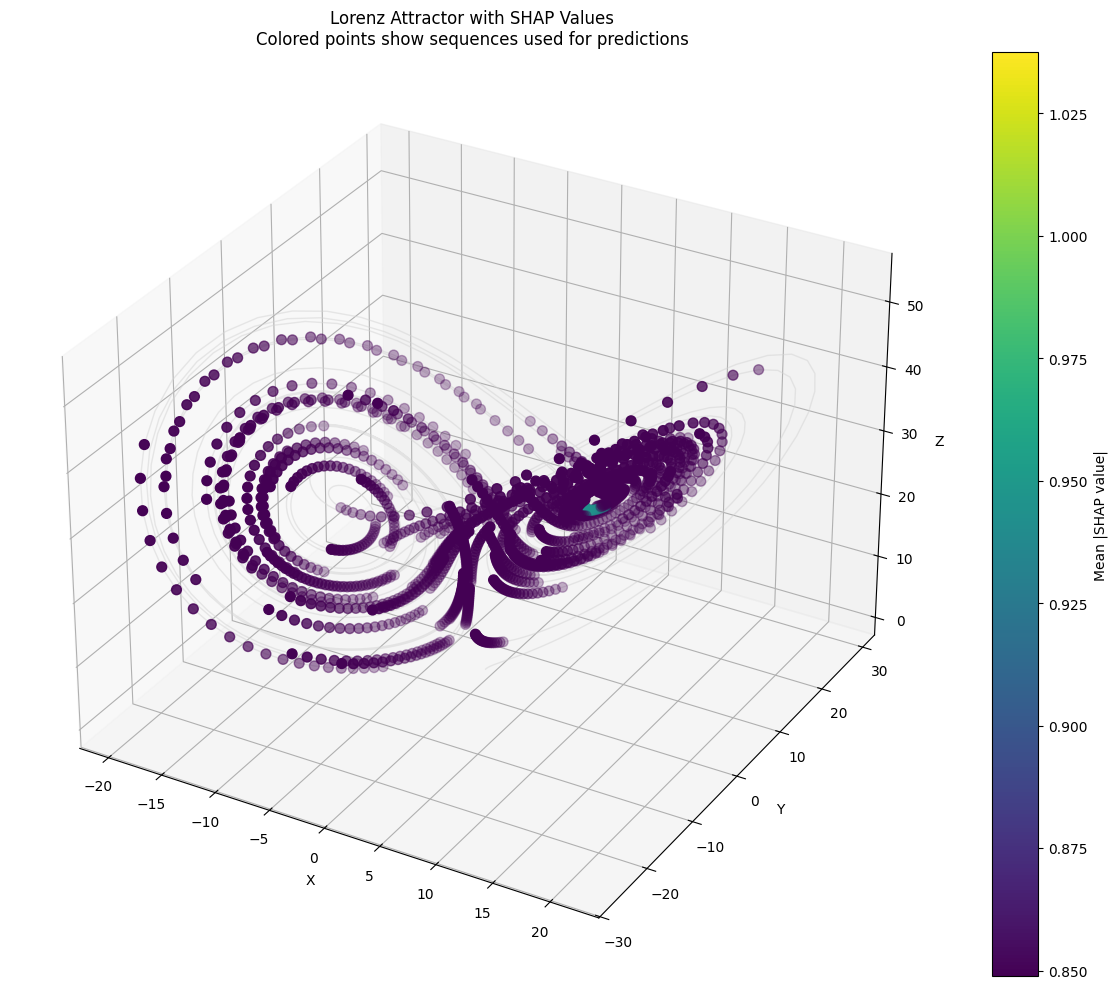


Feature Importance Summary:
t-19: 3.8972
t-18: 3.0615
t-17: 1.3843
t-11: 1.1773
t-16: 1.1029
t-4: 0.7577
t-12: 0.7562
t-14: 0.7163
t-0: 0.6632
t-2: 0.5144
t-13: 0.5077
t-3: 0.4541
t-8: 0.3831
t-15: 0.3436
t-6: 0.3148
t-7: 0.2273
t-10: 0.1874
t-1: 0.1739
t-5: 0.1274
t-9: 0.0626

Analysis completed in 34.02 seconds


In [ ]:
# First install required packages
!pip install shap tqdm IPython

import torch
import torch.nn as nn
import numpy as np
import shap
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
from IPython.display import Audio, display
import time

def generate_lorenz_full_state(n_samples=1000, sequence_length=20):
    """Generate Lorenz data with full state space (x, y, z)"""
    def lorenz(x, y, z, s=10, r=28, b=2.667):
        x_dot = s*(y - x)
        y_dot = r*x - y - x*z
        z_dot = x*y - b*z
        return x_dot, y_dot, z_dot

    dt = 0.01
    xs, ys, zs = [1], [1], [1]
    x, y, z = 1, 1, 1

    # Generate the full trajectory
    for i in range(n_samples + sequence_length):
        dx, dy, dz = lorenz(x, y, z)
        x = x + dx * dt
        y = y + dy * dt
        z = z + dz * dt
        xs.append(x)
        ys.append(y)
        zs.append(z)

    # Create sequences for x coordinate (for prediction)
    X = np.array([xs[i:i+sequence_length] for i in range(len(xs) - sequence_length)])
    y = np.array([xs[i+sequence_length] for i in range(len(xs) - sequence_length)])

    # Store full state trajectories
    full_state = np.array(list(zip(xs, ys, zs)))

    return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1), full_state

def plot_lorenz_shap(full_state, test_indices, shap_values, time_window=20):
    """Plot Lorenz attractor colored by SHAP values"""
    # Calculate average absolute SHAP value for each prediction
    mean_abs_shap = np.mean(np.abs(shap_values), axis=1)

    # Create figure
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Plot full attractor in light gray with more visibility
    ax.plot(full_state[:,0], full_state[:,1], full_state[:,2],
            color='lightgray', alpha=0.5, label='Full Trajectory', linewidth=1)

    # Print some statistics about SHAP values for verification
    print(f"SHAP value statistics:")
    print(f"Mean: {np.mean(mean_abs_shap):.4f}")
    print(f"Min: {np.min(mean_abs_shap):.4f}")
    print(f"Max: {np.max(mean_abs_shap):.4f}")
    print(f"Number of test points: {len(test_indices)}")

    # Plot points with SHAP values
    for i, test_idx in enumerate(test_indices):
        # Plot the sequence window used for prediction
        window_indices = range(test_idx, test_idx + time_window)
        points = full_state[window_indices]

        # Color based on mean absolute SHAP value for this prediction
        scatter = ax.scatter(points[:,0], points[:,1], points[:,2],
                           c=[mean_abs_shap[i]] * len(points),
                           cmap='viridis',
                           s=50)

    plt.colorbar(scatter, label='Mean |SHAP value|')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Lorenz Attractor with SHAP Values\nColored points show sequences used for predictions')
    plt.show()

# [Previous code for neural network and SHAP analysis remains the same...]

# Main execution
if __name__ == "__main__":
    print("Starting analysis...")
    start_time = time.time()

    # Generate data including full state
    print("Generating Lorenz data...")
    sequence_length = 20
    n_samples = 5000
    X, y, full_state = generate_lorenz_full_state(n_samples=n_samples,
                                                 sequence_length=sequence_length)

    # Create and train model
    print("Training model...")
    model = create_standard_net(sequence_length=sequence_length)
    trained_model = train_model(model, X, y)

    # Prepare model for SHAP
    print("Preparing SHAP analysis...")
    trained_model.eval()
    shap_wrapper = ShapWrapper(trained_model)

    # Create background data for SHAP (using first 100 samples)
    background_tensor = X[:100]

    # Select test instances for explanation (using next 10 samples)
    test_indices = range(100, 4500, 50)  # Store indices for visualization
    test_tensor = X[test_indices]

    # Initialize SHAP explainer
    print("Calculating SHAP values...")
    explainer = shap.DeepExplainer(shap_wrapper, background_tensor)

    # Calculate SHAP values and reshape
    shap_values = explainer.shap_values(test_tensor)
    shap_values = np.array(shap_values).squeeze()

    # Original SHAP plots
    test_data_numpy = test_tensor.numpy()
    feature_names = [f"t-{i}" for i in range(sequence_length)]

    # Regular SHAP summary plot
    plt.figure(figsize=(12, 6))
    shap.summary_plot(
        shap_values,
        test_data_numpy,
        feature_names=feature_names,
        show=False
    )
    plt.title("SHAP Summary Plot for Lorenz Prediction")
    plt.tight_layout()
    plt.show()

    # Plot SHAP values on Lorenz attractor
    print("\nCreating Lorenz attractor visualization...")
    plot_lorenz_shap(full_state, test_indices, shap_values,
                    time_window=sequence_length)

    # Print feature importance summary
    print("\nFeature Importance Summary:")
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    feature_importance = list(zip(feature_names, mean_abs_shap))
    sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

    for feature, importance in sorted_importance:
        print(f"{feature}: {importance:.4f}")

    # Print completion time and play sound
    end_time = time.time()
    print(f"\nAnalysis completed in {end_time - start_time:.2f} seconds")
    display(play_completion_sound())